Цель данной работы - выделить основные темы, поднимаемые в современной сетевой поэзии, с помощью методов машинного обучения, а именно латентного размещения Дирихле. 

В качестве источника данных используется десять различных пабликов ВКонтакте (российская социальная сеть), в которых публикуются современнные поэты. Паблики выбраны по следующим критериям: минимальное количество рекламных постов, минимальное содержание не стихотворных текстов, стандартизированная структура постов (допустим, сначала идет стихотворение, потом опциональна дата, затем имя автора), актуальность - последние публикации не раньше 2020 года.

Ключевые слова: тематическое моделирование, современная поэзия, сетевой анализ, машинное обучение, LDA.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/R_Poetry/Дубль два/План "минимум"/Данные/'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%capture
!pip install pymorphy2
!pip install pyLDAvis

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy2
import pymystem3
import pandas as pd
import numpy as np
import re
import json
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%%capture
nltk.download('stopwords')
nltk.download('punkt')
analyzer = pymorphy2.MorphAnalyzer()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

# Сбор данных

Следующий код позволяет собирать данные, но он не работает в Колабе, только в IDE.

In [ ]:
import json
import re
import time
import typing as tp
import pandas as pd
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry


VK_CONFIG = {
    "domain": "https://api.vk.com/method",
    "access_token": "",  # не надо токен на всеобщее обозрение выставлять...
    "version": "5.131",
}
MAX_NUMBER = 100


class Session:
    """
    Сессия.

    :param base_url: Базовый адрес, на который будут выполняться запросы.
    :param timeout: Максимальное время ожидания ответа от сервера.
    :param max_retries: Максимальное число повторных запросов.
    :param backoff_factor: Коэффициент экспоненциального нарастания задержки.
    """

    def __init__(
        self,
        base_url: str,
        timeout: float = 5.0,
        max_retries: int = 3,
        backoff_factor: float = 0.3,
    ) -> None:
        self.base_url = base_url
        self.timeout = timeout
        retry_strategy = Retry(
            total=max_retries,
            status_forcelist=[429, 500, 502, 503, 504],
            method_whitelist=["POST", "GET"],
            backoff_factor=backoff_factor,
        )
        self.adapter = HTTPAdapter(max_retries=retry_strategy)
        self.req = (requests.Session())
        self.req.mount(base_url, self.adapter)

    def get(self, url: str, *args: tp.Any, **kwargs: tp.Any) -> requests.Response:
        timeout = kwargs.get("timeout")
        if timeout is None:
            kwargs["timeout"] = self.timeout
        response = self.req.get(self.base_url + "/" + url, *args, **kwargs)
        return response

    def post(self, url: str, *args: tp.Any, **kwargs: tp.Any) -> requests.Response:
        timeout = kwargs.get("timeout")
        if timeout is None:
            kwargs["timeout"] = self.timeout
        response = self.req.post(self.base_url + "/" + url, *args, **kwargs)
        return response


def get_wall_execute(
    owner_id: str = "",
    domain: str = "",
    offset: int = 0,
    count: int = 10,
    max_count: int = 2500,
    filter: str = "owner",
    extended: int = 0,
    fields: tp.Optional[tp.List[str]] = None,
    file=None
) -> None:
    """
    Получает список постов со стены пользователя или сообщества и сохраняет в файл в формате json.

    @see: https://vk.com/dev/wall.get

    :param owner_id: Идентификатор пользователя или сообщества, со стены которого необходимо получить записи.
    :param domain: Короткий адрес пользователя или сообщества.
    :param offset: Смещение, необходимое для выборки определенного подмножества записей.
    :param count: Количество записей, которое необходимо получить (0 - все записи).
    :param max_count: Максимальное число записей, которое может быть получено за один запрос.
    :param filter: Определяет, какие типы записей на стене необходимо получить.
    :param extended: 1 — в ответе будут возвращены дополнительные поля profiles и groups, содержащие информацию о пользователях и сообществах.
    :param fields: Список дополнительных полей для профилей и сообществ, которые необходимо вернуть.
    :param file: имя файла, куда будут записаны данные
    """
    session_for_here = Session(VK_CONFIG["domain"])
    all_data = []
    start = time.time()
    for block in range(
        (count + MAX_NUMBER - 1) // MAX_NUMBER):  # на сколько блоков нужно разбить count
        code = """return API.wall.get({{"owner_id": "{0}", "domain": "{1}", "offset": "{2}", "count": "{3}", 
                                "max_count": "{4}", "filter": "{5}", "extended": "{6}", "fields": "{7}", "v": "{8}",
            }});""".format(owner_id, domain, block * MAX_NUMBER + offset, count, max_count, filter, extended,
                            fields, VK_CONFIG["version"])
        response = session_for_here.post(
            url="execute",
            data={
                "code": code,
                "access_token": VK_CONFIG["access_token"],
                "v": VK_CONFIG["version"],
            },
        )
        data = response.json()["response"]["items"]
        for piece in data:
            all_data.append(piece)
        if block % 25 == 0:
            if time.time() - start < 1:
                time.sleep(1 - (time.time() - start))  # обращаемся не чаще 25 раз в секунду
            start = time.time()

    new_data = []
    for item in all_data:
        if not item['marked_as_ads']:
            new_data.append({"text": item['text']})

    with open(file, "w", encoding='utf-8') as f:
        json.dump(new_data, f, indent=4, ensure_ascii=False)


if __name__ == "__main__":
    from_where = {"Чай со вкусом коммунальной квартиры": "-9073074",
                  "Написал я пару строк": "-126480671",
                  "Все поэты вконтакте": "-49870925",
                  "Стихоза": "-30018563",
                  "Хрустальные стихи": "-38087663",
                  "Лечебница": "-31691759",
                  "Dum spiro...": "-78486030",
                  "Стихи": "-32834527",
                  "Тысяча снежинок": "-54602160",
                  "Бабочки на стене": "-97304135"}
    for name, id in from_where.items():
      get_wall_execute(owner_id=id, count=5000, file=f'{name}.json')

Паблики, вошедшие в выборку, с примерами записей:

"Чай со вкусом коммунальной квартиры". Паблик содержит много поэтических текстов, мало рекламы. Есть пустые посты или посты-цитаты. Они обычно короткие, их можно отбросить с помощью взятия квантилей. Структура записи: стихотоворение + автор последней строкой. https://vk.com/public9073074 

хочешь в горести, хочешь в радости -

обещай мне дожить до старости.

до друзей, приходящих на чашечку в гости,

до стучащей по кафелю тоненькой трости.

до шуршащей, особенно мягкой листвы,

до красивой серебряной головы.

до туристов, летающих в миг на луну,

до времён, где однажды забудут войну.

до таинственной мудрости, в радость и муки

обещай мне увидеть, как женятся внуки.

обещай всё увидеть со мной наяву,

и тогда будь уверен - и я доживу.

© айсина шуклина

"Написал я пару строк". Мало рекламных постов, относительно много коротких текстов. Структура записи: стихотворение + хэштеги в конце. https://vk.com/napisalya 

Срывайся по первому зову,

О старых привычках молчи.

Обдумывай каждое слово

И лгать не ищи причин.

Да выбей ему скульптуру,

Кричи из последних сил.

Он тебя не полюбит, дура.

Он никого никогда не любил.

\#sokolova_няпс

"Все поэты вконтакте". Паблик, по содержанию похожий на предыдущий. Структура записи: стихотворение + имя автора. https://vk.com/public49870925 

БЕЗ НЕГО

Ты бродишь с тоской по мёртвым улицам города,

В надежде увидеть хотя бы тень, лишь касание…

Ветер, принеси ей отклик души его в знак сострадания;

Не будет желанней мотива и ближе этого повода.

Не горюй о прошлом, в нём оставаться бессмысленно.

Создай настоящее, достойное его жизненной памяти;

Чтобы было тепло и уютно в бушующем пламени

Твоей страсти к нему, что всё ещё тянется мысленно.

Время, как лечащий врач, всегда снимает симптомы.

Но шрамы в душе остаются, и с ними нам жить.

Опять смеяться, вновь примиряться, и снова любить.

Принимая свой путь, соблюдать этой жизни законы.


Александр Волков март 2022 г.

"СтиХозА • поэзия • проза". Много рекламных постов (которые marked_as_ads, поэтому убираются еще в процессе сбора данных). Структура записи: стихотворение + имя автора. https://vk.com/public_stihoza

Мы смотрели с ним на небеса,

По созвездиям путь составляли.

Я любила его, и в глазах

Новый мир по ночам изучала.

Я вселенную целую в них

Открывала, и без телескопа

Приближала тот сладостный миг

Распыления на изотопы.

Словно платье, спадала с меня

Вся застенчивость в приступах страсти.

Я читала: он любит меня!

По глазам его звёздно-прекрасным...

Заряна Зорина

"Хрустальные стихи". Реклама есть, но её не очень много. У стихотворений первой строчкой часто идет название. Структура записи: название (опционально) + стихотворение + имя автора. https://vk.com/public38087663

Эти капли стремительно падают вниз,

Разрезая апрельскую тьму.

Нет, я не устрою душевный стриптиз,

Да и правда тебе ни к чему.

Эти капли танцуют за мутным стеклом.

Я прошу, обойдемся без слов.

Нас весна не балует привычным теплом,

Надвигается время ветров.

Я тебе о проблемах своих не скажу,

Целый мир на мгновение исчез.

Я молчанием всё больше сейчас дорожу,

Как и ливнем, подарком небес.

Ирина Тюшина

"Лечебница". Хороший паблик, но как будто бы в нем достаточно редко выходят посты. Структура записи: стихотворение + имя автора. https://vk.com/h0spital

Ответить более правильно.

Заменить на менее искреннее, но и менее палевное.

Посыпать фальшивым, но обаятельным.

Сдаться им.

Улыбаться, когда голова в вакууме.

Дышать углекислым. Ну мало ли.

Крутить у виска при биении маятника_

Фуко_без надежды пил крафтовое.

А Дарвин ни капли не любил яблоки.

Зарисовки практически верных кругов [окружностей].

Три умноженное на 3 — почти что синоним вечности.

Пробитый снаружи обвинён в верности

Спутанным изнутри.

шепот светлячков

"Dum spiro...| Стихи, фото, арт". Структура записи: стихотворение + имя автора. https://vk.com/night.song

О счастье не кричат , громко

О счастье говорят тихо.

И если любовь взаимна.

Доказывать что то, нет смысла.

Укутавшись под теплым пледом,

Читать на расстоянии мысли.

Ловить в каждом слове песню.

И видеть в глазах ,искры

Не терпит любовь обмана.

От фальши она сгорает.

И жизнь превращается в пытку,

Где кто-то другим играет.

Взаимность и уважение,

Они дорогого стоят.

В любви не должно быть лишних.

В любви выживают двое.

\#Наталья_Ямницкая

"СТИХИ". Есть пустые посты, их немало. Структура записи: стихотворение + имя автора. https://vk.com/stihi_o_liubvi

какой бы на завтра прогноз не был -

дождь, снег, облачно или гроза,

каждый день я смотрю

в вечное

голубое

небо -

твои глаза.

asyaanisimova

"Тысяча снежинок. Стихи". Есть много хэштегов, они мешают, нужно будет чистить. Структура записи: хэштег с текстом + стихотворение + хэштег с текстом. https://vk.com/public54602160

\#Надежда_Смолич_Власова

ПРИКОСНУСЬ К ТЕБЕ

За водой мерцает серебристо,

В тёмной глади, белая луна.

И мерцают ласково игристо

Звёздочки, когда идёт волна...

Как мне горько, странно, одиноко

Наблюдать, смотря на небеса,

Зная, что с подругой синеокой

Ты уплыл, поднявши паруса...

Задыхаясь, по грозе томится

Знойный берег, в лунном серебре.

Ну, а мне бы легкокрылой птицей

Прикоснуться вновь к твоей судьбе...

\#тысяча_снежинок_стихи

"Бабочки на стене". Хороший паблик. Структура записи: стихотворение + автор/дата. https://vk.com/butterflies_wall

* * *

Неизбежно чувствуется всеми,

Как уходит безвозвратно время.

И в разы растёт число проблем

Оттого, что убегает врем..

Но ребята строят во дворе

Замки из песка, ведь детворе

Дела нет, что ускользает вре...

2016

© Роман Поплавский

# Первичная предобработка (удаление лишнего, токенизация)

Порядок обработки текста: 


1. Удаляем всё, что идет после хэштегов (между \# и пробелом)
2. Удаляем последнюю строчку - это чаще всего имя автора/дата написания стихотворения. Даже если это не так, одна строчка сильно не повлияет на определение смысла текста
2. Оставляем только символы русского алфавита (удаляем пунктуацию, скобки, цифры, латиницу)
3. Приводим символы к нижнему регистру
4. Токенизируем текст



In [ ]:
def preprocessing(text):
  text = re.sub("#.*(?: |\n)", " ", text)
  text = " ".join(text.split('\n')[:-1])
  text = re.sub("[^а-яА-ЯёЁ]", " ", text).lower()
  list_of_words = word_tokenize(text, language="russian")
  return list_of_words, len(list_of_words)

def preprocess_to_file(input_files, path, output_file):
  list_for_json = []
  for file_name in input_files:
    data = json.load(open(path + file_name + ".json"))
    print(f"{file_name}: {len(data)}")
    for item in data:
      text, length = preprocessing(item['text'])
      list_for_json.append({"word_list": text, "length": length})
  with open(path + output_file, "w", encoding='utf-8') as f:
    json.dump(list_for_json, f, indent=4, ensure_ascii=False)

In [ ]:
preprocess_to_file(input_files=["Чай со вкусом коммунальной квартиры", "Написал я пару строк",
                                "Все поэты вконтакте", "Стихоза", "Хрустальные стихи",
                                "Лечебница", "Dum spiro...", "Стихи", "Тысяча снежинок",
                                "Бабочки на стене"], 
                   path=PATH, 
                   output_file="all_poetry.json")

Чай со вкусом коммунальной квартиры: 9931
Написал я пару строк: 4989
Все поэты вконтакте: 5000
Стихоза: 4835
Хрустальные стихи: 4981
Лечебница: 5000
Dum spiro...: 4995
Стихи: 4709
Тысяча снежинок: 5000
Бабочки на стене: 1000


# Анализ количества слов, "обрезка" выборки

In [ ]:
data = pd.read_json(PATH + 'all_poetry.json')
data.head(5)

,word_list,length
0,"[что, было, до, бесконечной, тугой, пустоты, р...",89
1,"[разве, стоит, плакаться, и, звереть, что, суд...",128
2,"[здесь, под, медленный, танец, марта, и, зов, ...",135
3,[],0
4,"[родился, где, гагарин, с, поднятыми, руками, ...",15


Общий размер датасета:

In [ ]:
data.shape[0]

50440

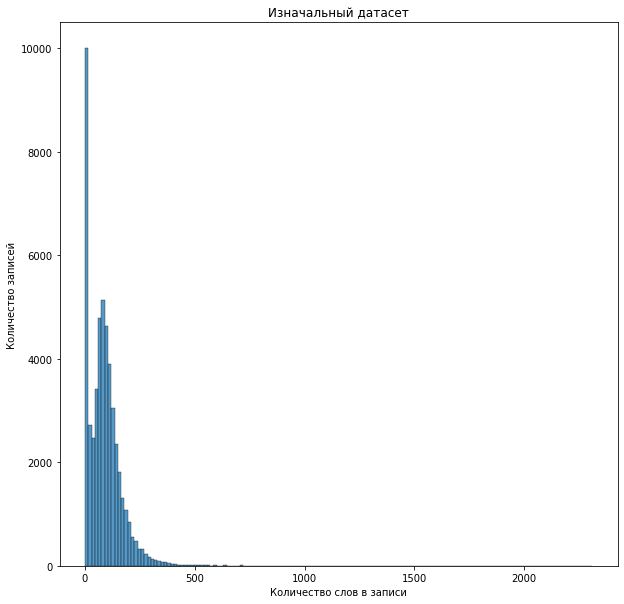

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.histplot(x=data['length'], binwidth=15)
ax.set(title="Изначальный датасет", xlabel="Количество слов в записи", ylabel='Количество записей')
plt.show()

Как видно по графику, распределение неравномерно. Существует пик около нуля. Можно предположить, что его составляют пустые записи (например, содержащие только фото без текста) и короткие тексты-цитаты. Записи, количество слов в которых превышает 500, тоже вызывают подозрение. Посмотрим информацию о датасете. 

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
length,50440.0,88.066753,81.236969,0.0,29.0,80.0,123.0,2297.0


In [ ]:
data.describe(percentiles=[.25, .90]).T

,count,mean,std,min,25%,50%,90%,max
length,50440.0,88.066753,81.236969,0.0,29.0,80.0,177.0,2297.0


Установим нижнюю границу слов в 30, верхнюю - в 200. Тогда график распределения будет выглядеть следующим образом:

In [ ]:
lower_bound, upper_bound = 30, 200
cropped_data = data[(data.length >= lower_bound) & (data.length <= upper_bound)]

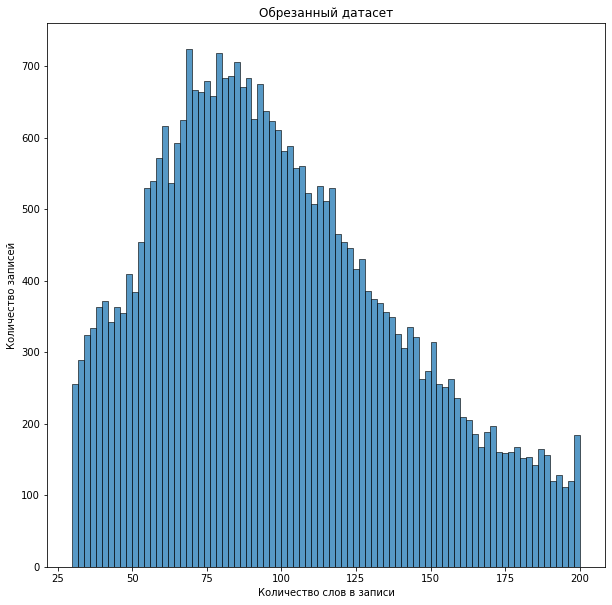

In [ ]:
plt.figure(figsize=(10, 10))
ax = sns.histplot(x=cropped_data.length, binwidth=2)
ax.set(title="Обрезанный датасет", xlabel="Количество слов в записи", ylabel='Количество записей')
plt.show()

Размер обрезанного датасета:

In [ ]:
cropped_data.shape[0]

34292

# Вторичная предобработка (лемматизация, стоп-слова)

Для расширения списка стоп-слов и более корректной работы алгоритма возьмем 3000 случайных текстов и проведем их частотный анализ. На основе получившихся данных вычленим дополнительные стоп-слова.

In [ ]:
for_stop_words = cropped_data.sample(3000)
for_stop_words.head(5)

,word_list,length
49008,"[моё, вчера, подобно, сну, моё, сегодня, как, ...",195
26225,"[сколько, ретуши, не, накладывай, блеска, в, г...",83
34303,"[в, этом, заброшенном, мире, живут, бестолковы...",71
47402,"[желание, на, улице, тихо, уснула, весна, мы, ...",84
33073,"[у, весны, шелушилась, бледная, кожа, в, лужах...",54


In [ ]:
def lemmatize(list_of_words):
  norm_words = [analyzer.parse(word)[0].normal_form for word in list_of_words]
  return norm_words

In [ ]:
for_stop_words['lemmatized'] = for_stop_words.word_list.map(lemmatize)

In [ ]:
def remove_existing_stopwords(list_of_words):
  stops = stopwords.words("russian")
  norm_words = [w for w in list_of_words if w not in stops]
  return norm_words

In [ ]:
for_stop_words['removed_existing_stopwords'] = [" ".join(remove_existing_stopwords(item)) for item in for_stop_words.lemmatized]
for_stop_words.head(5)

,word_list,length,lemmatized,removed_existing_stopwords
49008,"[моё, вчера, подобно, сну, моё, сегодня, как, ...",195,"[мой, вчера, подобно, сон, мой, сегодня, как, ...",вчера подобно сон сегодня завтра заворотиться ...
26225,"[сколько, ретуши, не, накладывай, блеска, в, г...",83,"[сколько, ретушь, не, накладывать, блеск, в, г...",сколько ретушь накладывать блеск глаз добавить...
34303,"[в, этом, заброшенном, мире, живут, бестолковы...",71,"[в, это, забросить, мир, жить, бестолковый, те...",это забросить мир жить бестолковый тень пленни...
47402,"[желание, на, улице, тихо, уснула, весна, мы, ...",84,"[желание, на, улица, тихо, уснуть, весна, мы, ...",желание улица тихо уснуть весна счастливый еха...
33073,"[у, весны, шелушилась, бледная, кожа, в, лужах...",54,"[у, весна, шелушиться, бледный, кожа, в, лужа,...",весна шелушиться бледный кожа лужа растечься п...


Посмотрим на первые по частоте встречаемости в текстах 3000 слов и отберем среди них дополнительные стоп-слова:

In [ ]:
cv = CountVectorizer()
cv.fit_transform(for_stop_words.removed_existing_stopwords).toarray()
response = cv.transform([" ".join(for_stop_words.removed_existing_stopwords)])
feature_array = np.array(cv.get_feature_names())
cv_sorting = np.argsort(response.toarray()).flatten()[::-1]

In [ ]:
n = 3000
with open('output_cv.txt', 'w', encoding='utf-8') as file:
    print("\n".join(feature_array[cv_sorting][:n]), file=file)

Итоговая функция лемматизации и удаления стоп-слов будет выглядеть следующим образом:

In [ ]:
def preprocessing(list_of_words, normal_forms={"герд": "герда", "счастие": "счастье",
                                               "человечек": "человек"}, 
                  remove_stopwords=False):
    norm_words = []
    for word in list_of_words:  # лемматизация
      word = analyzer.parse(word)[0].normal_form
      norm_words.append(normal_forms[word] if word in normal_forms.keys() else word)
    if remove_stopwords:  # убираем стоп-слова
      stops = stopwords.words("russian") + ['всё', 'это', 'твой', 'свой', 'весь', 
                'пусть', 'ещё', 'который', 'её', 'словно', 'пока', 'очень', 'самый', 
                'сколько', 'сквозь', 'чей', 'вокруг', 'любой', 'слишком', 'почему', 
                'среди', 'значит', 'ваш', 'тысяча', 'ночью', 'однажды', 'сегодня', 
                'завтра', 'вчера', 'послезавтра', 'позавчера', 'нибыть', 'точно', 
                'уметь', 'целый', 'полный', 'часть', 'увы', 'эй', 'ох', 'ах', 'эх', 
                'готовый', 'хотя', 'как', 'столько', 'равно', 'оно', 'похожий', 
                'скоро', 'разный', 'всякий', 'порой', 'часто', 'настоящий', 'вместо', 
                'сто', 'сотня', 'вовсе', 'пожалуйста', 'спасибо', 'иметь', 'вроде', 
                'наверное', 'три', 'четыре', 'пять', 'шесть', 'семь', 'восемь', 
                'девять', 'десять', 'пускай', 'мимо', 'частый', 'сей', 'привет', 
                'наверно', 'туда', 'иль', 'возможно', 'вено', 'иной', 'едва', 
                'поэтому', 'впереди', 'зря', 'вообще', 'меж', 'мол', 'нету', 'наш',
                'иначе', 'всякий', 'ради', 'оттого', 'нечего', 'скорее', 'здравствуй', 
                'пред', 'сначала', 'вряд', 'случайно', 'коль', 'многий', 'кроме', 
                'откуда', 'нынче', 'ибо', 'порою', 'вне', 'кой', 'еле', 'разом', 
                'ка', 'либо', 'зато', 'сорок', 'везде', 'таков', 'вон', 'покуда', 
                'затем', 'особенно', 'мэри', 'несмотря', 'сотый', 'всюду', 'ти', 
                'возле', 'кстати', 'прям', 'ныне', 'бай', 'предельно', 'тая', 
                'чрез', 'юрий', 'некий', 'впредь', 'практически', 'лишь', 'каждый',
                'день', 'год', 'хороший', 'плохой', 'большой', 'маленький', 'мочь', 
                'коли', 'найти', 'просто', 'нужно', 'снова', 'первый', 'второй', 
                'третий', 'вновь', 'казаться', 'мало', 'много', 'считать', 'ть',
                'ксения', 'газиев', 'мила', 'паблик', 'дать', 'смотреть',
                'й', 'ц', 'у', 'к', 'е', 'н', 'г', 'ш', 'щ', 'з', 'х', 'ъ', 'ф',
                'ы', 'в', 'а', 'п', 'р', 'о', 'л', 'д', 'ж', 'э', 'я', 'ч', 'с',
                'м', 'и', 'т', 'ь', 'б', 'ю', 'глаз', 'рука', 'любовь',
                'любить', 'жизнь', 'жить', 'мир', 'душа', 'сердце']
      norm_words = [w for w in norm_words if w not in stops]
    return norm_words

# Создание корпуса текстов

In [ ]:
cropped_data['preprocessed'] = [preprocessing(item, remove_stopwords=True) for item in cropped_data.word_list]

In [ ]:
cropped_data.sample(5)

,word_list,length,preprocessed
12604,"[ненужный, бумажный, хлам, переплачется, переб...",190,"[ненужный, бумажный, хлам, переплакаться, пере..."
24917,"[я, с, тобой, не, пойду, в, разведку, далеко, ...",90,"[пойти, разведка, далеко, уйти, отряд, дрожать..."
32122,"[привидением, буду, у, твоего, дома, кружить, ...",66,"[привидение, дом, кружить, никто, дорожить, ки..."
32450,"[давай, уедем, подальше, от, этого, мира, купи...",92,"[давать, уехать, далёкий, купить, дом, снять, ..."
17546,"[и, опять, я, влюбился, не, в, ту, и, опять, м...",64,"[влюбиться, молодой, приятный, нагота, понятны..."


Создание корпуса:

In [ ]:
id2word = corpora.Dictionary(cropped_data["preprocessed"])
id2word.filter_extremes(no_above=0.8, no_below=20)
id2word.compactify()
print(id2word)

Dictionary(9639 unique tokens: ['агония', 'бесконечный', 'боль', 'вдвоём', 'вместе']...)


In [ ]:
corpus = [id2word.doc2bow(text) for text in cropped_data["preprocessed"]]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]


# Выбор количества тем, построение модели

In [ ]:
def coherence_score(dictionary, corpus, texts, limit, start=2, step=2, measure="c_v"):
    """
    Функция вычисляет метрики для оценки тем. моделирования и выводит 
    график, где по оси x отложено количество топиков, а по оси y - значение 
    метрики. Возвращает лучшее количество тем.
    :param dictionary: словарь для тематического моделирования
    :param corpus: корпус в виде мешка слов
    :param texts: тексты документов
    :param limit: максимальное количество топиков
    :param start: стартовое количество топиков
    :param step: промежуток, с которым вычисляются топики
    :param measure: метрика
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                                           random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=measure)
        coherence_values.append(coherencemodel.get_coherence())
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Количество тем")
    plt.ylabel("Согласованность")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    return x[coherence_values.index(max(coherence_values))]  # лучшее количество тем

100%|██████████| 13/13 [11:28<00:00, 52.98s/it]


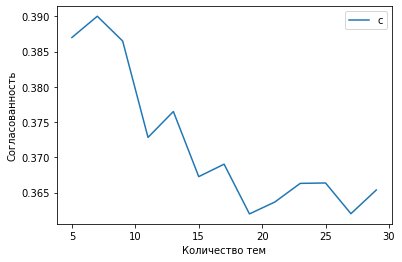

In [ ]:
best_num_topics = coherence_score(dictionary=id2word, corpus=corpus, texts=cropped_data["preprocessed"], start=5, limit=30, step=2)

In [ ]:
best_num_topics

7

In [ ]:
model=LdaMulticore(corpus=corpus, id2word=id2word, num_topics=best_num_topics, passes=10, random_state=42)

In [ ]:
list_of_topics = []
for item in model.print_topics(num_words=40):
  list_of_topics.append(" ".join(re.findall(r'[а-яА-ЯёЁ]+', item[1])))
pd.DataFrame(list_of_topics, columns=['Наиболее часто встречающиеся слова темы'])

,Наиболее часто встречающиеся слова темы
0,боль губа слово тело кожа кровь палец взгляд в...
1,счастье хотеть стать свет друг сон знать слово...
2,дождь снег осень окно город ветер весна лето н...
3,небо свет земля звезда ветер ночь море луна со...
4,друг хотеть говорить ночь знать давать сказать...
5,человек знать друг стать слово время сказать в...
6,дом мама ребёнок бог идти война мать детство с...


In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.151548 -0.063542       1        1  24.178688
1     -0.010110 -0.121630       2        1  15.073045
2      0.105979  0.055794       3        1  13.959720
0      0.030720 -0.171890       4        1  13.199333
3      0.240183  0.007678       5        1  13.095870
4     -0.214132  0.061095       6        1  11.175464
6     -0.001092  0.232495       7        1   9.317880, topic_info=           Term         Freq        Total Category  logprob  loglift
541        небо  6055.000000  6055.000000  Default  30.0000  30.0000
3087      осень  2652.000000  2652.000000  Default  29.0000  29.0000
1013       снег  2865.000000  2865.000000  Default  28.0000  28.0000
154        друг  7434.000000  7434.000000  Default  27.0000  27.0000
209       дождь  3083.000000  3083.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
957   вернуться   383.873670  1521.975564   Topic7  -5.9339   0.9958
973        нога   390.221125  1817.093328   Topic7  -5.9175   0.8350
1494      город   391.965911  3441.957483   Topic7  -5.9130   0.2006
2547     родный   364.961071  2098.567229   Topic7  -5.9844   0.6240
623   последний   347.154785  2077.619638   Topic7  -6.0344   0.5840

[578 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8195      6  0.995948    абонент
5741      3  0.995444     август
8598      7  0.987864       авто
6392      3  0.997250      аллея
4682      6  0.984466       банк
...     ...       ...        ...
794       2  0.099636         яд
794       4  0.697454         яд
794       5  0.047285         яд
9517      4  0.989961         як
5050      3  0.993053  январский

[1545 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 3, 1, 4, 5, 7])

Попробуем поставить чуть больше тем.

In [ ]:
model=LdaMulticore(corpus=corpus, id2word=id2word, num_topics=12, passes=3, random_state=42)

In [ ]:
list_of_topics = []
for item in model.print_topics(num_words=40):
  list_of_topics.append(" ".join(re.findall(r'[а-яА-ЯёЁ]+', item[1])))
pd.DataFrame(list_of_topics, columns=['Наиболее часто встречающиеся слова темы'])

,Наиболее часто встречающиеся слова темы
0,друг губа чувство слово сон знать боль тело ви...
1,хотеть боль слово стать слеза чувство сила зна...
2,город дождь время окно улица человек помнить с...
3,поэт давать свет ночь чёрный ветер путь живой ...
4,друг говорить ждать человек ночь дом кошка дав...
5,знать друг человек хотеть стать сказать слово ...
6,мама дом ребёнок детство ждать стать мать сказ...
7,стена чёрный нога тело кожа песок говорить вид...
8,женщина стать мужчина знать девочка красивый п...
9,снег осень ветер свет небо дождь весна сон сол...


In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.152850  0.002304       1        1  18.334555
9      0.138272  0.013961       2        1  13.304685
10     0.005185 -0.101244       3        1  12.766843
11     0.210901  0.055055       4        1   7.943564
4     -0.071274  0.144053       5        1   7.493208
0     -0.064679 -0.135084       6        1   6.688418
1     -0.094620 -0.114866       7        1   6.462911
2      0.065216  0.079079       8        1   6.402359
6     -0.022319  0.135157       9        1   6.308407
7      0.079076 -0.098859      10        1   5.459939
8     -0.152872  0.082467      11        1   5.270067
3      0.059966 -0.062022      12        1   3.565043, topic_info=          Term         Freq        Total Category  logprob  loglift
154       друг  7652.000000  7652.000000  Default  30.0000  30.0000
1494     город  3695.000000  3695.000000  Default  29.0000  29.0000
1173   женщина  1798.000000  1798.000000  Default  28.0000  28.0000
2425      мама  1692.000000  1692.000000  Default  27.0000  27.0000
541       небо  6070.000000  6070.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
4146  рисовать   148.512308  1151.594505  Topic12  -5.9227   1.2858
2161  холодный   156.119360  1743.026935  Topic12  -5.8728   0.9212
612       лицо   160.658708  2698.045400  Topic12  -5.8441   0.5130
103      знать   161.029844  9022.880698  Topic12  -5.8418  -0.6919
150     голова   149.407531  2467.806030  Topic12  -5.9167   0.5296

[1047 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
40        1  0.090377       ад
40        3  0.455453       ад
40        4  0.017838       ад
40        6  0.097512       ад
40        7  0.026162       ад
...     ...       ...      ...
794      12  0.078280       яд
9517      6  0.986627       як
6930      3  0.985245  яркость
3205      3  0.962582  яростно
3205      9  0.017501  яростно

[4553 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 11, 12, 5, 1, 2, 3, 7, 8, 9, 4])

# Итоги

https://docs.google.com/document/d/1NCXUWYR9ZJUvVmkyTTwNICRijOAzcjwecuBjq98k5kA/edit